# Visualizing Avg W2V on Amazon Fine Food Review Dataset

#### 1.Import statements

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

# !pip install -U gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import re
import os


from tqdm import tqdm

#### 2. Connecting to the Database file using pandas library and retriving the data from 'CleanedText' column

* This Data is the result of the data pre-processing in the 'Data Pre-processing for t-SNE on Amazon Review Dataset.ipynb' file on the Amazon Fine Food Review Dataset. The review data from the original dataset is processed(cleaned) and stored in the same db file for further use.

In [2]:
#Access reviews data from 'final.sqlite' file
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

 ####   3. Dimensionality reduction of the TAvg W2V Vectors for Review text using t-SNE in Scikit-Learn
 
* Steps:
    1) Get all the sentences from the 'CleanedText' field and split them as list of sentences.
    
    2) Convert all the list of sentences to Word2Vec using Word2Vec from gensim.models module. The parameters used are as follows:
        a) list_of_sent/sentences: list of lists of sentences.
        b) min_count: Ignores all words with total frequency lower than min_count. Ex: min_count = 5.
        c) size: Dimensionality of the resulting word vectors. Ex: size=50.
        d) workers: no. of worker threads to train the model(=faster training with multicore machines). Ex: workers=14.
     
     3) Convert all the sentences from the 'CleanedText' to TF-IDF vectors
     
     4) Once both these values are obtained the following is done:
        a) Get the W2V vector for a word.
        b) Get the average of all the W2V vectors and divide each word W2V with it to get the Avg W2V.
      
     5) After obtaining the result from the above step, get the first 30000 datapoints from the dataset and apply dimensionality reduction using t-SNE and plot the points in 2D.

In [3]:
# Training own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [4]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=14)

In [5]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  21938
sample words  ['mccormack', 'maynard', 'javacabana', 'mediat', 'buckl', 'drawer', 'slaveri', 'alimentum', 'saber', 'jetfuel', 'scallop', 'himilayan', 'tentat', 'spokesperson', 'unchew', 'kellog', 'sezm', 'sheepish', 'unmatch', 'diagnois', 'drv', 'perfor', 'wors', 'test', 'whirlypop', 'obligatori', 'hefe', 'friski', 'schwan', 'pincer', 'underpin', 'regim', 'accur', 'predict', 'definatley', 'medela', 'squeezer', 'glutino', 'lizano', 'yogitea', 'ntingw', 'yeh', 'rampag', 'scovil', 'luxuri', 'statin', 'vitamix', 'petco', 'lanolin', 'ladden']


In [6]:
# average Word2Vec
# compute average word2vec for each review.
list_of_sent = list_of_sent[0:30000]
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 30000/30000 [09:28<00:00, 52.76it/s]

30000
50


#### 4. Plotting TF-IDF Weighted W2V vectors using Seaborn

364171
30000
30000
30000


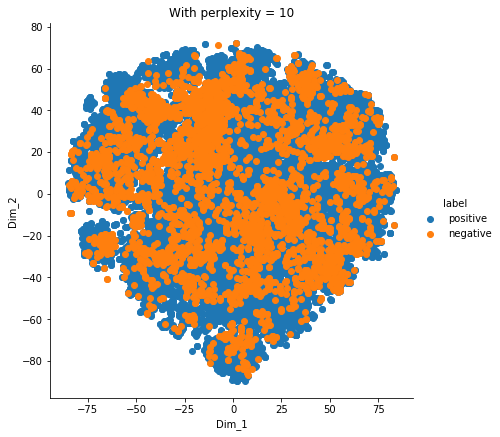

In [7]:
# from sklearn.manifold import TSNE
top_5000 = sent_vectors
labels = final['Score']
print(len(labels))
labels_5000 = labels[0:30000]
print(len(labels_5000))


from sklearn.preprocessing import StandardScaler
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
top_5000 = sc.fit_transform(top_5000)



from MulticoreTSNE import MulticoreTSNE as TSNE

tsne_model = TSNE(n_jobs = 14, n_components=2, random_state=0, perplexity=10, n_iter=5000)
tsne_data = tsne_model.fit_transform(top_5000)

print(len(tsne_data))
print(len(labels_5000))

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.title('With perplexity = 10')
plt.show()

30000
30000


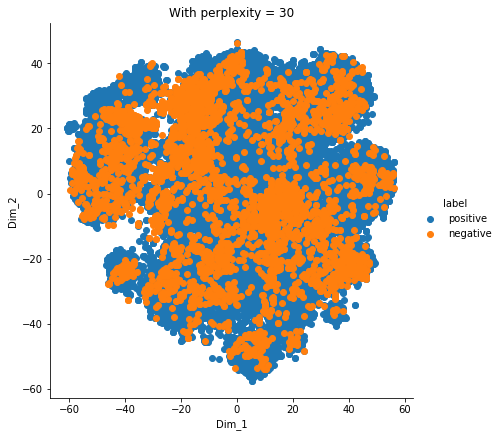

In [8]:
tsne_model = TSNE(n_jobs = 14, n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_data = tsne_model.fit_transform(top_5000)

print(len(tsne_data))
print(len(labels_5000))

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.title('With perplexity = 30')
plt.show()


30000
30000


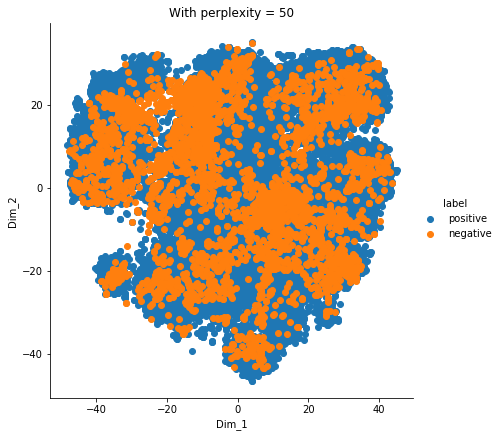

In [9]:
tsne_model = TSNE(n_jobs = 14, n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data = tsne_model.fit_transform(top_5000)

print(len(tsne_data))
print(len(labels_5000))

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.title('With perplexity = 50')
plt.show()

30000
30000


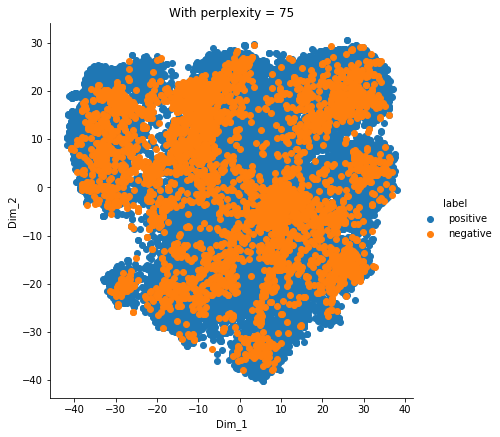

In [10]:
tsne_model = TSNE(n_jobs = 14, n_components=2, random_state=0, perplexity=75, n_iter=5000)
tsne_data = tsne_model.fit_transform(top_5000)

print(len(tsne_data))
print(len(labels_5000))

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.title('With perplexity = 75')
plt.show()

30000
30000


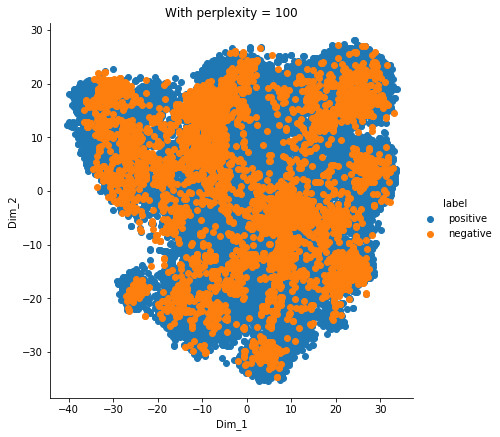

In [11]:
tsne_model = TSNE(n_jobs = 14, n_components=2, random_state=0, perplexity=100, n_iter=5000)
tsne_data = tsne_model.fit_transform(top_5000)

print(len(tsne_data))
print(len(labels_5000))

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.title('With perplexity = 100')
plt.show()

# Observations:

* At first glance all the graphs are different in their overall shape and clustering is very good compared to all the previous techniques but the positive and negative points grouping suffers a lot of overlap between them.

* Eventhough W2V considers the semantic meaning of the words, there are lot of words that are common between the positive and the negative reviews and also the dimensionality of the W2V vectors has been reduced from 50-D to 2-D which gives us the overlapped plot.

* Avg W2V plot can be considered as the overall well clustered data visualization plot because a very few points are scattered across the plot and all of points in the plot belonging to a class stayed really close to cluster.

* As the perplexity increased in the different plots, the shape of the plot also has changed due to more number of similar points are trying to be closer as a group. This is pronounced more in Avg W2V than in others.